In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
from tqdm import tqdm
import openml
import sklearn
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
import matplotlib.pyplot as plt
import random
import numpy as np
import seaborn as sns
import re

import pickle
import category_encoders

### Preprocessing Data

In [21]:
'''
Downloading additional data from OpenML
'''
df_openml = pd.read_csv('df_openml_all2.csv', index_col=[0])

uniq_task_id = list(set(df_openml['task_id']))
tasks = pd.DataFrame(columns = openml.tasks.list_tasks(task_id = [uniq_task_id[0]], output_format="dataframe").columns)
for i in tqdm(uniq_task_id):
    tasks = tasks.append(openml.tasks.list_tasks(task_id = [i], output_format="dataframe"))

datasets = openml.datasets.list_datasets(output_format = 'dataframe')
# tasks = openml.tasks.list_tasks(output_format="dataframe")
flows = openml.flows.list_flows(output_format = 'dataframe')
suites = openml.study.list_suites(output_format="dataframe", status="all")

datasets = datasets.rename(columns={'did': 'data_id', 'name': 'data_name'})
tasks = tasks.rename(columns={'did': 'data_id', 'tid': 'task_id', 'name': 'data_name'})
flows = flows.rename(columns={'full_name': 'flow_name', 'name': 'flow_name_type', 'id': 'flow_id'})

100%|██████████| 1793/1793 [20:20<00:00,  1.47it/s]


In [ ]:
'''
Downloading data from OpenML
'''
# df_openml = pd.DataFrame()
# tasks.task_id.unique()

# for i in tqdm(tasks.task_id.unique()):
#     try:
#         df_openml = df_openml.append(openml.evaluations.list_evaluations(
#             function = 'area_under_roc_curve',
#             tasks = [i],
#             output_format='dataframe',
#             size = None))
#     except:
#         None

# df_openml.to_csv('df_openml_all2.csv')

In [23]:
# Отавляем модели только с sklearn
df_openml_sklearn = df_openml[df_openml['flow_name'].str.startswith('sklearn')]
# Удаление одинаковых моделей для каждого task_id, оставляя с лучшим score
data_with_best_model = df_openml_sklearn.groupby(['task_id','flow_name']).apply(lambda x: x.nlargest(1,['value'])).reset_index(drop=True)

data_with_best_model.loc[data_with_best_model[data_with_best_model['value']>=0.8].index, 'label'] = 1
data_with_best_model.loc[data_with_best_model[data_with_best_model['value']<0.8].index, 'label'] = 0

# TOP_POS = 3    # количество лучших моделей для каждого task_id
# TOP_NEG = 7    # количество худших моделей для каждого task_id 

# # Оставляем только те task_id, для которых количество samples >= TOP_POS + TOP_NEG 
# temp = data_with_best_model['task_id'].value_counts()
# data_with_best_model = data_with_best_model[data_with_best_model['task_id'].isin(list(temp[temp>=TOP_POS+TOP_NEG].index))]

# # POSITIVE_SAMPLES
# df_top_positive = data_with_best_model.groupby(['task_id']).apply(lambda x: x.nlargest(TOP_POS,['value']))
# df_top_positive['label'] = [1]*len(df_top_positive)
# # NEGATIVE_SAMPLES
# df_top_negative = data_with_best_model.groupby(['task_id']).apply(lambda x: x.nsmallest(TOP_NEG,['value']))
# df_top_negative['label'] = [0]*len(df_top_negative)

# df_top = pd.concat([df_top_positive, df_top_negative])

# Объединение различных таблиц с OpenML (например, доп информация о датасете и тд)
df_top_merge = pd.merge(data_with_best_model, datasets[list(set(datasets.columns) - set(data_with_best_model.columns)) + ['data_name', 'data_id']], on = ['data_name', 'data_id'])
df_top_merge = pd.merge(df_top_merge, tasks[list(set(tasks.columns) - set(df_top_merge.columns)) + ['task_id', 'data_id']], on = ['task_id', 'data_id'])
df_top_merge = pd.merge(df_top_merge, flows[list(set(flows.columns) - set(df_top_merge.columns)) + ['flow_id', 'flow_name']], on = ['flow_id', 'flow_name'])

# Преобразование информации о модели
df_top_merge['flow_count_transformes'] = df_top_merge['flow_name_type'].apply(lambda x: x.count('='))
df_top_merge["flow_main"] = df_top_merge["flow_name_type"].apply(lambda x: re.findall(r'(.*?[(])', x)[0][:-1] if re.findall(r'(.*?[(])', x) else None) 
df_top_merge["flow_main"] = df_top_merge["flow_main"].apply(lambda x: 'sklearn.pipeline.C...' if str(x).startswith('sklearn.pipeline.C') else x) 
df_top_merge["flow_model"] = df_top_merge["flow_name_type"].apply(lambda x: x.split('.')[-1].rstrip(')')) 
df_top_merge['flow_list_of_transforms'] = df_top_merge["flow_name_type"].apply(lambda x: frozenset([i[1:-1] for i in re.findall(r'([(,].*?[=])', x)]) if re.findall(r'([(,].*?[=])', x) else None)

# df_top_merge.to_csv('OpenML_neg+pos.csv')

# Удаление дубликатов по модели
df_top_merge_sort = df_top_merge.sort_values(by=['value'], ignore_index=True, ascending=False)
df_top_merge_sort.drop_duplicates(subset=['flow_model','flow_list_of_transforms','task_id'], inplace=True)

temp = df_top_merge_sort['task_id'].value_counts()
N = 2
df_top_merge = df_top_merge_sort[df_top_merge_sort['task_id'].isin(list(temp[temp>=N].index))]

In [9]:
# with open('pipelines.pickle', 'wb') as file:
#     pickle.dump(np.array(df_top_merge["flow_name_type"]), file)


In [24]:
count_str_pipeline = []
branch_pipelines = []

for i in df_top_merge['flow_name_type']:
    count_str_pipeline.append(i.lower().count('pipeline'))
    if [True for cond in ['columntransformer', 'featureunion', 'make_union'] if cond in i.lower()]:
        branch_pipelines.append(i)

several_pipeline = len([x for x in count_str_pipeline if x > 2]), len(df_top_merge['flow_name_type'])
#pd.Series(count_str_pipeline).value_counts()
print(len(branch_pipelines))

1606


In [4]:
# df_top_merge = pd.read_csv('OpenML_neg+pos.csv')

In [25]:
# Удаление неинформативных столбцов
columns = set(df_top_merge.columns) - set(['ttid', 'cost_matrix', 'Unnamed: 0.1', 'target_feature_left','function', 'format', 'Unnamed: 0', 'run_id',	'setup_id',	'flow_id', 'flow_name', 'data_id', 'data_name', 'upload_time',
                                            'uploader', 'uploader_name', 'values',	'array_data', 'version', 'status', 'target_value',	'target_feature_right',
                                            'target_feature_event',	'quality_measure',	'source_data',	'source_data_labeled',	'number_samples', 'external_version',
                                            'estimation_procedure', 'task_type', 'target_feature', 'flow_main']) #'flow_name_type'
X_columns = list(columns - {'label'}) #{'value', 'task_id'}
Y_column = ['label']

In [32]:
X_dataset = df_top_merge[set(X_columns)-set(['flow_list_of_transforms', 'flow_count_transformes','flow_model','flow_name_type', 'task_id', 'evaluation_measures', 'value'])]
X_dataset.to_csv('X_dataset.csv')

In [33]:
X_dataset.head()

,NumberOfInstances,MinorityClassSize,MajorityClassSize,NumberOfMissingValues,NumberOfNumericFeatures,NumberOfInstancesWithMissingValues,NumberOfFeatures,MaxNominalAttDistinctValues,NumberOfSymbolicFeatures,NumberOfClasses
0,2126.0,53.0,579.0,0.0,35.0,0.0,36.0,10.0,1.0,10.0
1,1372.0,610.0,762.0,0.0,4.0,0.0,5.0,2.0,1.0,2.0
2,2796.0,274.0,680.0,68100.0,32.0,2795.0,35.0,57.0,3.0,6.0
3,8124.0,3916.0,4208.0,2480.0,0.0,2480.0,23.0,12.0,23.0,2.0
4,8124.0,3916.0,4208.0,2480.0,0.0,2480.0,23.0,12.0,23.0,2.0


In [81]:
X = df_top_merge[X_columns]
y = df_top_merge[Y_column]

# Заполнение пропусков и преобразование категориальных данных
cols=X.select_dtypes(include='object').columns.to_list() 
    
X[cols] = X[cols].fillna('nan')
X[cols] = X[cols].astype(str)
X[list(set(X.columns)-set(cols))] = X[list(set(X.columns)-set(cols))].fillna(-1)

# enc = OneHotEncoder() #OrdinalEncoder(dtype = int)
# enc.fit(X[cols])
# transform_X = pd.DataFrame(enc.transform(X[cols]).toarray())
# transform_X.index = X.index
# X = pd.concat([X[set(X.columns) - set(cols)], transform_X], axis = 1)
# X.columns = X.columns.astype(str)

enc = OrdinalEncoder(dtype = int)
enc.fit(X[cols])
X[cols] = enc.transform(X[cols])

dict_category = dict()
for col in cols:
    dict_category[col] = X[col].nunique()
# with open('dict_category_2.pkl', 'wb') as f:
#     pickle.dump(dict_category, f) 

# enc = category_encoders.BinaryEncoder(cols=cols)
# data_binary = enc.fit_transform(X[cols])
# X = pd.concat([data_binary, X[list(set(X.columns)-set(cols))]], axis=1) 

# Разделение данных на train и test по task_id
task_id_uniq = df_top_merge['task_id'].unique()
SIZE_TRAIN = 0.8
train_task_id = random.sample(list(task_id_uniq), round(len(task_id_uniq)*SIZE_TRAIN))
test_task_id = list(set(task_id_uniq) - set(train_task_id))

X_train = X[X.index.isin(list(df_top_merge[df_top_merge['task_id'].isin(train_task_id)].index))]
y_train = y[y.index.isin(list(df_top_merge[df_top_merge['task_id'].isin(train_task_id)].index))]

X_test = X[X.index.isin(list(df_top_merge[df_top_merge['task_id'].isin(test_task_id)].index))]
y_test = y[y.index.isin(list(df_top_merge[df_top_merge['task_id'].isin(test_task_id)].index))]

# X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, test_size=0.2, random_state=42, stratify=X[['task_id']])

/tmp/ipykernel_146820/62334551.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[cols] = X[cols].fillna('nan')
/tmp/ipykernel_146820/62334551.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[cols] = X[cols].astype(str)
/tmp/ipykernel_146820/62334551.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/inde

In [41]:
# X_train.to_csv('X_train_2.csv')
# X_test.to_csv('X_test_2.csv')

In [25]:
df_top_merge.groupby(['flow_model','flow_list_of_transforms','task_id']).size().max()

1

### Metrics

In [79]:
def eval(y_pos, y_neg):
        hits1_list = []
        hits3_list = []
        hits7_list = []
        mrr_list = []
        for y_pred_neg,y_pred_pos in zip(y_neg, y_pos):
                y_pred = np.concatenate([y_pred_pos, y_pred_neg])
                # ranking_list = (len(y_pred) - y_pred.argsort().argsort())
                ranking_list = (len(y_pred) - y_pred.argsort().argsort())[:len(y_pred)//2]
                hits1_list.append(int(any(ranking_list[:1] <= 1)))
                hits3_list.append(int(all(ranking_list[:3] <= 3)))
                hits7_list.append(int(all(ranking_list[:7] <= 7)))
                # mrr_list.append(np.mean(1./(np.where(ranking_list == 1)[0]+1)))  
                mrr_list.append(np.mean(1./ranking_list))   
        return np.mean(mrr_list), np.mean(hits1_list), np.mean(hits3_list), np.mean(hits7_list)

In [8]:
from scipy.stats import rankdata
import math
def dcg(order):
    log = 0
    for i,o in enumerate(order):
        log += o/math.log(1+i+1,2)
    return np.array(log)

def ndcg(y_true_list, y_score_list):
    _ndcg = []

    for y_true,y_score in zip(y_true_list, y_score_list):
        rank = rankdata(y_true, method='min')
        rank_true = rankdata(y_true[(-1*rank).argsort()], method='max')-1
        rank_pred = rankdata(y_score[(-1*rank).argsort()], method='max')-1
        
        idcg = np.mean(dcg(rank_true))
        _dcg = np.mean(dcg(rank_pred))

        _ndcg.append(_dcg/idcg)

    return np.mean(_ndcg)

### Baseline

In [67]:
test_data = X_test.copy()
test_data['prob'] = [random.random() for _ in range(len(test_data))]
test_data = pd.concat([test_data, y_test], axis = 1)
preds_class = [1 if i>0.5 else 0 for i in test_data['prob']]
y_neg = np.array(test_data[test_data['label'] == 0].groupby('task_id')['prob'].apply(list))
y_pos = np.array(test_data[test_data['label'] == 1].groupby('task_id')['prob'].apply(list))
y_true = test_data.groupby('task_id')['value'].apply(list)
y_pred = test_data.groupby('task_id')['prob'].apply(list)
y_true = np.array([y_true.values[i] for i in range(len(y_true))])
y_pred = np.array([y_pred.values[i] for i in range(len(y_pred))])

print(f'F1-score: {sklearn.metrics.f1_score(y_test, preds_class)}')
print(f'NDCG_sklearn: {sklearn.metrics.ndcg_score(y_true, y_pred)}')
print(f'NDCG_my_implementation: {ndcg(y_true, y_pred)}')
mrr, hits1, hits3, hits7 = eval(y_pos, y_neg)
print()
print ('HITS@K все POS_ElEMENTS содержатся в предсказанных TOP-K')
print(f'HITS@1: {hits1}')
print(f'HITS@3: {hits3}')
print(f'HITS@7: {hits7}')
print(f'MRR: {mrr}')

F1-score: 0.41269841269841273
NDCG_sklearn: 0.9309437136431487
NDCG_my_implementation: 0.7650036217632606

HITS@K все POS_ElEMENTS содержатся в предсказанных TOP-K
HITS@1: 0.16
HITS@3: 0.0
HITS@7: 0.4
MRR: 0.3203121693121693


### Popular 

In [44]:
from collections import defaultdict
rating = np.array(X_train.groupby(['task_id']).apply( lambda x: x.sort_values(['value'], ascending=False) )['flow_name_type']).reshape(-1,10)
rating_dict = defaultdict(float)

for i in range(len(rating)): 
    for j in range(TOP_POS):
        rating_dict[rating[i][j]] += 1*TOP_POS/(j+1)
    for j in range(TOP_POS, TOP_NEG+TOP_POS):
        rating_dict[rating[i][j]] += -1*(j+1)/TOP_NEG

# plt.bar(rating_dict.keys(), rating_dict.values())

preds_proba = [rating_dict[i] for i in X_test['flow_name_type']]
preds_class = [1 if i>0 else 0 for i in preds_class]

test_data = X_test.copy()
test_data['prob'] = preds_proba
test_data = pd.concat([test_data, y_test], axis = 1)
y_neg = np.array(test_data[test_data['label'] == 0].groupby('task_id')['prob'].apply(list))
y_pos = np.array(test_data[test_data['label'] == 1].groupby('task_id')['prob'].apply(list))
y_true = test_data.groupby('task_id')['value'].apply(list)
y_pred = test_data.groupby('task_id')['prob'].apply(list)
y_true = np.array([y_true.values[i] for i in range(len(y_true))])
y_pred = np.array([y_pred.values[i] for i in range(len(y_pred))])

print(f'F1-score: {sklearn.metrics.f1_score(y_test, preds_class)}')
print(f'NDCG_sklearn: {sklearn.metrics.ndcg_score(y_true, y_pred)}')
print(f'NDCG_my_implementation: {ndcg(y_true, y_pred)}')
mrr, hits1, hits3, hits7 = eval(y_pos, y_neg)
print()
print ('HITS@K все POS_ElEMENTS содержатся в предсказанных TOP-K')
print(f'HITS@1: {hits1}')
print(f'HITS@3: {hits3}')
print(f'HITS@7: {hits7}')
print(f'MRR: {mrr}')

F1-score: 0.0
NDCG_sklearn: 0.9810297047808503
NDCG_my_implementation: 0.9422144397332325

HITS@K все POS_ElEMENTS содержатся в предсказанных TOP-K
HITS@1: 0.56
HITS@3: 0.44
HITS@7: 0.8
MRR: 0.4948624338624338


### Normalization

In [9]:
from sklearn.preprocessing import MinMaxScaler

def norm(data):
    def f(x):
        scaler1=MinMaxScaler()
        x['norm'] = scaler1.fit_transform(x[['value']])
        return x

    data_ = data.groupby(['task_id']).apply(f)
    y = data_['norm']
    return y

## Regression

/tmp/ipykernel_146820/3596457889.py:22: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  y_true = np.array([y_true.values[i] for i in range(len(y_true))])
/tmp/ipykernel_146820/3596457889.py:23: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  y_pred = np.array([y_pred.values[i] for i in range(len(y_pred))])


NDCG_sklearn: 0.9394645137499098
NDCG_my_implementation: 0.9182987022408455

HITS@K все POS_ElEMENTS содержатся в предсказанных TOP-K
HITS@1: 0.36904761904761907
HITS@3: 0.32142857142857145
HITS@7: 0.5833333333333334
MRR: 0.45083008690376464


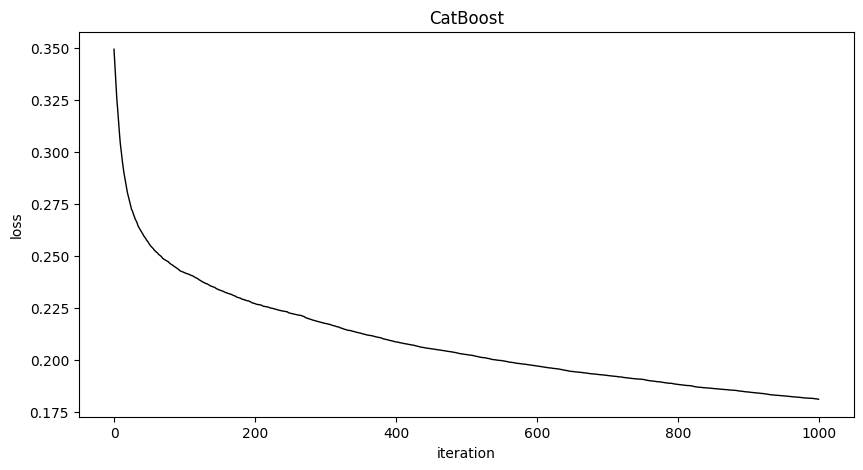

In [82]:
from catboost import CatBoostRegressor, Pool

y_train_norm = norm(X_train)
y_test_norm = norm(X_test)


pool_train = Pool(X_train[list(set(X_train.columns) - {'value', 'task_id'})], y_train_norm, cat_features = list(dict_category.keys()))
pool_test = Pool(X_test[list(set(X_test.columns) - {'value', 'task_id'})], cat_features = list(dict_category.keys()))

model = CatBoostRegressor(random_state=1, iterations=1000, verbose=False)
model.fit(pool_train)
preds_proba = model.predict(pool_test)

test_data = X_test.copy()
test_data['prob'] = preds_proba
test_data['value'] = y_test_norm
test_data = pd.concat([test_data, y_test], axis = 1)
y_neg = np.array(test_data[test_data['label'] == 0].groupby('task_id')['prob'].apply(list))
y_pos = np.array(test_data[test_data['label'] == 1].groupby('task_id')['prob'].apply(list))
y_true = test_data.groupby('task_id')['value'].apply(np.array)
y_pred = test_data.groupby('task_id')['prob'].apply(np.array)
y_true = np.array([y_true.values[i] for i in range(len(y_true))])
y_pred = np.array([y_pred.values[i] for i in range(len(y_pred))])

fig = plt.figure(figsize=(10,5))
fig.patch.set_facecolor('xkcd:white')
plt.plot(model.evals_result_['learn']['RMSE'], color = 'black', linewidth=1)
plt.title('CatBoost')
plt.xlabel("iteration")
plt.ylabel("loss")

ndcg_score_skl = []
for idx in range(len(y_true)):
    ndcg_score_skl.append(sklearn.metrics.ndcg_score([y_true[idx]], [y_pred[idx]])) 

print(f'NDCG_sklearn: {np.mean(ndcg_score_skl)}')
print(f'NDCG_my_implementation: {ndcg(y_true, y_pred)}')
mrr, hits1, hits3, hits7 = eval(y_pos, y_neg)
print()
print ('HITS@K все POS_ElEMENTS содержатся в предсказанных TOP-K')
print(f'HITS@1: {hits1}')
print(f'HITS@3: {hits3}')
print(f'HITS@7: {hits7}')
print(f'MRR: {mrr}')

/tmp/ipykernel_146820/4185440585.py:21: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  y_true = np.array([y_true.values[i] for i in range(len(y_true))])
/tmp/ipykernel_146820/4185440585.py:22: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  y_pred = np.array([y_pred.values[i] for i in range(len(y_pred))])


NDCG_sklearn: 0.7865257265121461
NDCG_my_implementation: 0.7229960354185071

HITS@K все POS_ElEMENTS содержатся в предсказанных TOP-K
HITS@1: 0.07608695652173914
HITS@3: 0.2717391304347826
HITS@7: 0.5
MRR: 0.3084439888725718


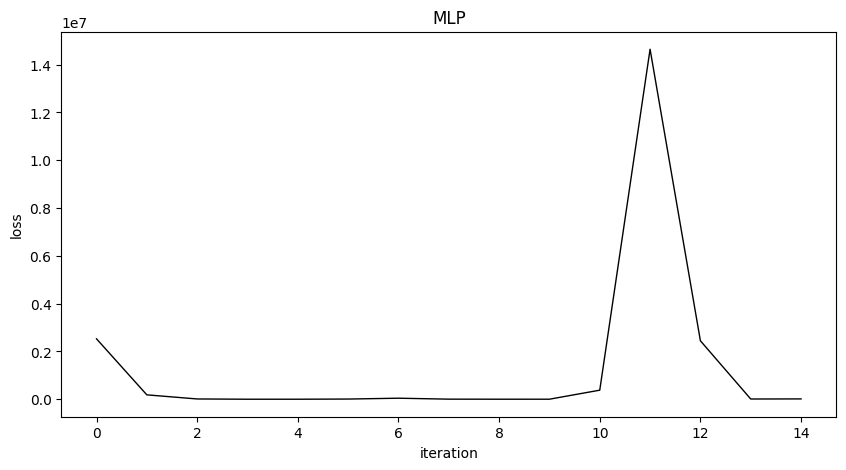

In [78]:
from sklearn.neural_network import MLPRegressor

y_train_norm = norm(X_train)
y_test_norm = norm(X_test)

clf = MLPRegressor(random_state=1, 
                    max_iter=1000,
                    verbose = False)

clf.fit(X_train[list(set(X_train.columns) - {'value', 'task_id'})], y_train_norm)
preds_proba = clf.predict(X_test[list(set(X_test.columns) - {'value', 'task_id'})])

test_data = X_test.copy()
test_data['prob'] = preds_proba
test_data['value'] = y_test_norm
test_data = pd.concat([test_data, y_test], axis = 1)
y_neg = np.array(test_data[test_data['label'] == 0].groupby('task_id')['prob'].apply(list))
y_pos = np.array(test_data[test_data['label'] == 1].groupby('task_id')['prob'].apply(list))
y_true = test_data.groupby('task_id')['value'].apply(np.array)
y_pred = test_data.groupby('task_id')['prob'].apply(np.array)
y_true = np.array([y_true.values[i] for i in range(len(y_true))])
y_pred = np.array([y_pred.values[i] for i in range(len(y_pred))])

fig = plt.figure(figsize=(10,5))
fig.patch.set_facecolor('xkcd:white')
plt.plot(clf.loss_curve_, color = 'black', linewidth=1)
plt.title('MLP')
plt.xlabel("iteration")
plt.ylabel("loss")

ndcg_score_skl = []
for idx in range(len(y_true)):
    ndcg_score_skl.append(sklearn.metrics.ndcg_score([y_true[idx]], [y_pred[idx]]))

print(f'NDCG_sklearn: {np.mean(ndcg_score_skl)}')
print(f'NDCG_my_implementation: {ndcg(y_true, y_pred)}')
mrr, hits1, hits3, hits7 = eval(y_pos, y_neg)
print()
print ('HITS@K все POS_ElEMENTS содержатся в предсказанных TOP-K')
print(f'HITS@1: {hits1}')
print(f'HITS@3: {hits3}')
print(f'HITS@7: {hits7}')
print(f'MRR: {mrr}')

### CatBoost

/tmp/ipykernel_920854/3633819575.py:22: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  y_true = np.array([y_true.values[i] for i in range(len(y_true))])
/tmp/ipykernel_920854/3633819575.py:23: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  y_pred = np.array([y_pred.values[i] for i in range(len(y_pred))])


F1-score: 0.7091670544439274
NDCG_sklearn: 0.9887497583625292
NDCG_my_implementation: 0.8974712719807446

HITS@K все POS_ElEMENTS содержатся в предсказанных TOP-K
HITS@1: 0.32222222222222224
HITS@3: 0.35555555555555557
HITS@7: 0.6333333333333333
MRR: 0.4257618012967043


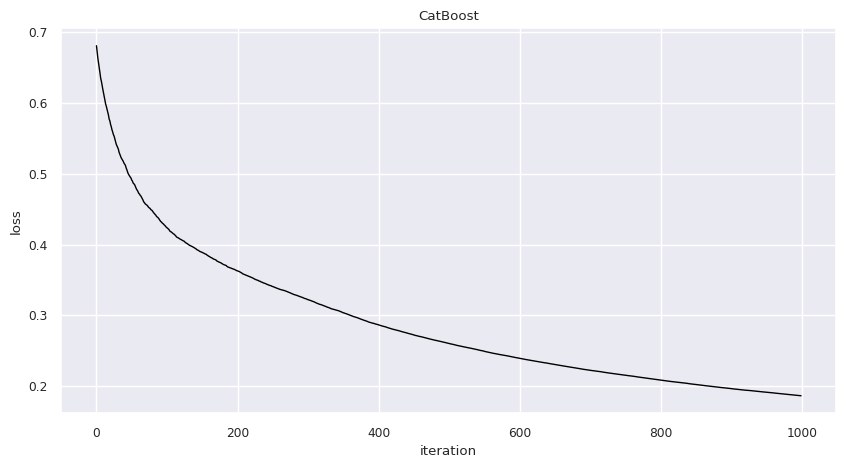

In [179]:
from catboost import CatBoostClassifier, Pool

pool_train = Pool(X_train[list(set(X_train.columns) - {'value', 'task_id'})], y_train, cat_features = list(dict_category.keys()))
pool_test = Pool(X_test[list(set(X_test.columns) - {'value', 'task_id'})], cat_features = list(dict_category.keys()))

model = CatBoostClassifier(random_state=1, iterations=1000,
                           learning_rate=0.03,
                            l2_leaf_reg=3,
                            loss_function='CrossEntropy',
                           depth=6, verbose=False)
model.fit(pool_train)
preds_class = model.predict(pool_test)
preds_proba = model.predict_proba(pool_test)

test_data = X_test.copy()
test_data['prob'] = preds_proba[:,1]
test_data = pd.concat([test_data, y_test], axis = 1)
y_neg = np.array(test_data[test_data['label'] == 0].groupby('task_id')['prob'].apply(list))
y_pos = np.array(test_data[test_data['label'] == 1].groupby('task_id')['prob'].apply(list))
y_true = test_data.groupby('task_id')['value'].apply(np.array)
y_pred = test_data.groupby('task_id')['prob'].apply(np.array)
y_true = np.array([y_true.values[i] for i in range(len(y_true))])
y_pred = np.array([y_pred.values[i] for i in range(len(y_pred))])

fig = plt.figure(figsize=(10,5))
fig.patch.set_facecolor('xkcd:white')
plt.plot(model.evals_result_['learn']['CrossEntropy'], color = 'black', linewidth=1)
plt.title('CatBoost')
plt.xlabel("iteration")
plt.ylabel("loss")

print(f'F1-score: {sklearn.metrics.f1_score(y_test, preds_class)}')
ndcg_score_skl = []
for idx in range(len(y_true)):
    ndcg_score_skl.append(sklearn.metrics.ndcg_score([y_true[idx]], [y_pred[idx]])) 

print(f'NDCG_sklearn: {np.mean(ndcg_score_skl)}')
print(f'NDCG_my_implementation: {ndcg(y_true, y_pred)}')
mrr, hits1, hits3, hits7 = eval(y_pos, y_neg)
print()
print ('HITS@K все POS_ElEMENTS содержатся в предсказанных TOP-K')
print(f'HITS@1: {hits1}')
print(f'HITS@3: {hits3}')
print(f'HITS@7: {hits7}')
print(f'MRR: {mrr}')

plt.savefig(fname = "./catboost.png", dpi=300, facecolor='w', edgecolor='w',
            orientation='portrait', format=None, 
            transparent=False, bbox_inches=None, pad_inches=0.1,
            metadata=None)

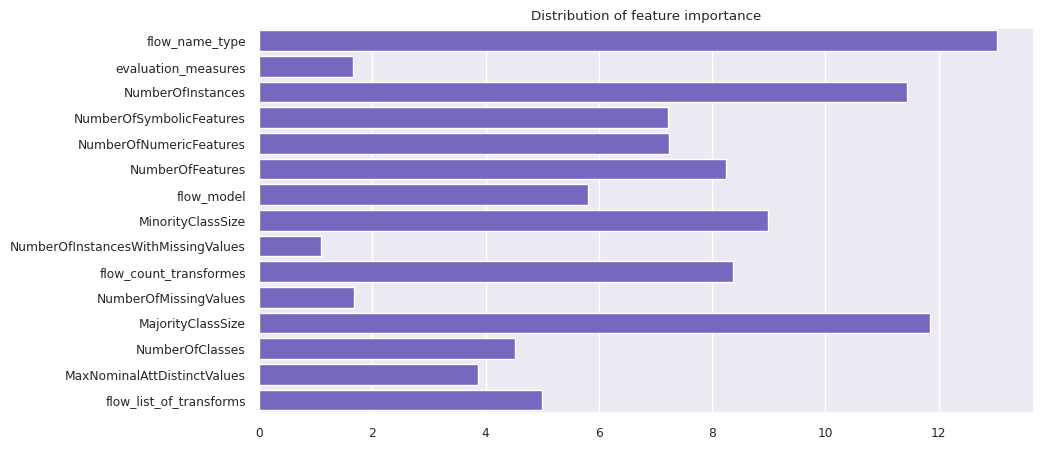

In [169]:
cols = X_train[list(set(X_train.columns) - {'value', 'task_id'})].columns
values = model.get_feature_importance()

fig = plt.figure(figsize=(10,5))
fig.patch.set_facecolor('xkcd:white')
sns.set(font_scale=0.8)
palette = sns.color_palette("crest", as_cmap=True)
plt.title('Distribution of feature importance')
sns.barplot(y=cols, x=values, palette=['slateblue']*len(cols))

plt.savefig(fname = "./fig/get_feature_importance.png", dpi=300, facecolor='w', edgecolor='w',
            orientation='portrait',bbox_inches='tight')

### MLPClassifier

/data/home/eegorova/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1091: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/tmp/ipykernel_920854/1841509076.py:18: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  y_true = np.array([y_true.values[i] for i in range(len(y_true))])
/tmp/ipykernel_920854/1841509076.py:19: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  y_pred = np.array([

F1-score: 0.7182009838369642
NDCG_sklearn: 0.9730655236333511

HITS@K все POS_ElEMENTS содержатся в предсказанных TOP-K
HITS@1: 0.13186813186813187
HITS@3: 0.2967032967032967
HITS@7: 0.5274725274725275
MRR: 0.327783267367679


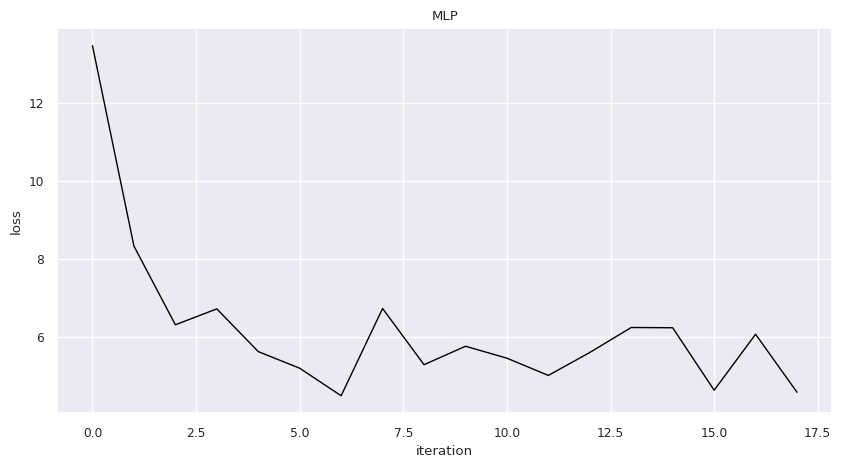

In [176]:
from sklearn.neural_network import MLPClassifier

clf = MLPClassifier(random_state=1, 
                    max_iter=1000,
                    verbose = False)

clf.fit(X_train[list(set(X_train.columns) - {'value', 'task_id'})], y_train)
preds_class = clf.predict(X_test[list(set(X_test.columns) - {'value', 'task_id'})])
preds_proba = clf.predict_proba(X_test[list(set(X_test.columns) - {'value', 'task_id'})])

test_data = X_test.copy()
test_data['prob'] = preds_proba[:,1]
test_data = pd.concat([test_data, y_test], axis = 1)
y_neg = np.array(test_data[test_data['label'] == 0].groupby('task_id')['prob'].apply(list))
y_pos = np.array(test_data[test_data['label'] == 1].groupby('task_id')['prob'].apply(list))
y_true = test_data.groupby('task_id')['value'].apply(np.array)
y_pred = test_data.groupby('task_id')['prob'].apply(np.array)
y_true = np.array([y_true.values[i] for i in range(len(y_true))])
y_pred = np.array([y_pred.values[i] for i in range(len(y_pred))])

fig = plt.figure(figsize=(10,5))
fig.patch.set_facecolor('xkcd:white')
plt.plot(clf.loss_curve_, color = 'black', linewidth=1)
plt.title('MLP')
plt.xlabel("iteration")
plt.ylabel("loss")

print(f'F1-score: {sklearn.metrics.f1_score(y_test, preds_class)}')
ndcg_score_skl = []
for idx in range(len(y_true)):
    ndcg_score_skl.append(sklearn.metrics.ndcg_score([y_true[idx]], [y_pred[idx]])) 

print(f'NDCG_sklearn: {np.mean(ndcg_score_skl)}')
# print(f'NDCG_my_implementation: {ndcg(y_true, y_pred)}')
mrr, hits1, hits3, hits7 = eval(y_pos, y_neg)
print()
print ('HITS@K все POS_ElEMENTS содержатся в предсказанных TOP-K')
print(f'HITS@1: {hits1}')
print(f'HITS@3: {hits3}')
print(f'HITS@7: {hits7}')
print(f'MRR: {mrr}')


### LogisticRegression

In [37]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(random_state=1)

clf.fit(X_train[list(set(X_train.columns) - {'value', 'task_id'})], y_train)
preds_class = clf.predict(X_test[list(set(X_test.columns) - {'value', 'task_id'})])
preds_proba = clf.predict_proba(X_test[list(set(X_test.columns) - {'value', 'task_id'})])

test_data = X_test.copy()
test_data['prob'] = preds_proba[:,1]
test_data = pd.concat([test_data, y_test], axis = 1)
y_neg = np.array(test_data[test_data['label'] == 0].groupby('task_id')['prob'].apply(list))
y_pos = np.array(test_data[test_data['label'] == 1].groupby('task_id')['prob'].apply(list))
y_true = test_data.groupby('task_id')['value'].apply(list)
y_pred = test_data.groupby('task_id')['prob'].apply(list)
y_true = np.array([y_true.values[i] for i in range(len(y_true))])
y_pred = np.array([y_pred.values[i] for i in range(len(y_pred))])

print(f'F1-score: {sklearn.metrics.f1_score(y_test, preds_class)}')
print(f'NDCG_sklearn: {sklearn.metrics.ndcg_score(y_true, y_pred)}')
print(f'NDCG_my_implementation: {ndcg(y_true, y_pred)}')
mrr, hits1, hits3, hits7 = eval(y_pos, y_neg)
print()
print ('HITS@K все POS_ElEMENTS содержатся в предсказанных TOP-K')
print(f'HITS@1: {hits1}')
print(f'HITS@3: {hits3}')
print(f'HITS@7: {hits7}')
print(f'MRR: {mrr}')

/data/home/eegorova/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:1141: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


F1-score: 0.0
NDCG_sklearn: 0.9581526043663249
NDCG_my_implementation: 0.8407176032787944

HITS@K все POS_ElEMENTS содержатся в предсказанных TOP-K
HITS@1: 0.2
HITS@3: 0.24
HITS@7: 0.8
MRR: 0.42987830687830686


/data/home/eegorova/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### SVM

In [41]:
from sklearn.svm import SVC

clf = SVC(random_state=1, probability=True)

clf.fit(X_train[list(set(X_train.columns) - {'value', 'task_id'})], y_train)
preds_class = clf.predict(X_test[list(set(X_test.columns) - {'value', 'task_id'})])
preds_proba = clf.predict_proba(X_test[list(set(X_test.columns) - {'value', 'task_id'})])

test_data = X_test.copy()
test_data['prob'] = preds_proba[:,1]
test_data = pd.concat([test_data, y_test], axis = 1)
y_neg = np.array(test_data[test_data['label'] == 0].groupby('task_id')['prob'].apply(list))
y_pos = np.array(test_data[test_data['label'] == 1].groupby('task_id')['prob'].apply(list))
y_true = test_data.groupby('task_id')['value'].apply(list)
y_pred = test_data.groupby('task_id')['prob'].apply(list)
y_true = np.array([y_true.values[i] for i in range(len(y_true))])
y_pred = np.array([y_pred.values[i] for i in range(len(y_pred))])

print(f'F1-score: {sklearn.metrics.f1_score(y_test, preds_class)}')
print(f'NDCG_sklearn: {sklearn.metrics.ndcg_score(y_true, y_pred)}')
print(f'NDCG_my_implementation: {ndcg(y_true, y_pred)}')
mrr, hits1, hits3, hits7 = eval(y_pos, y_neg)
print()
print ('HITS@K все POS_ElEMENTS содержатся в предсказанных TOP-K')
print(f'HITS@1: {hits1}')
print(f'HITS@3: {hits3}')
print(f'HITS@7: {hits7}')
print(f'MRR: {mrr}')

/data/home/eegorova/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:1141: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


F1-score: 0.0
NDCG_sklearn: 0.8748003416211196
NDCG_my_implementation: 0.6965330683778072

HITS@K все POS_ElEMENTS содержатся в предсказанных TOP-K
HITS@1: 0.0
HITS@3: 0.04
HITS@7: 0.24
MRR: 0.16526455026455025


### MLP with RANKNET

In [66]:
import torch
from torch import nn
from torch.optim import Optimizer
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data import Dataset

BATCH_SIZE = 32
EPOCH = 100
NUM_WORKERS = 8
LEARNING_RATE = 0.0001
device = torch.device("cpu") #mps

In [67]:
class pair_dataset(Dataset):
    def __init__(self,data):
    
        self.data = data
        self.x1 = torch.tensor(np.array(self.data[list(set(self.data.columns) - {'value', 'task_id'})]), dtype=torch.float32) #dtype=torch.float16
        self.y1 = np.array(self.data['value'])

        self.x2 = pd.DataFrame()
        self.y2 = np.array([])
        for i in self.data.index:
            new_row = self.data[self.data['task_id'] == self.data['task_id'][i]].drop(index=i,columns =['value','task_id']).sample(n=1)
            self.x2 = self.x2.append(new_row)
            self.y2 = np.append(self.y2, self.data['value'][new_row.index])

        self.x2 = torch.tensor(np.array(self.x2), dtype=torch.float32) #dtype=torch.float16
        self.y2 = np.array(self.y2)

        self.compare = torch.tensor([1.0 if t1 > t2 else 0.0 if t1 < t2 else 0.5 for t1,t2 in zip(self.y1,self.y2)], dtype=torch.float32) #dtype=torch.float16

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.x1[idx], self.x2[idx], self.compare[idx]

In [77]:
class MLP_RankNet(nn.Module):
    def __init__(self):
        super(MLP_RankNet, self).__init__()
        self.fc1 = nn.Linear(18, 10)
        self.bn = torch.nn.BatchNorm1d(num_features=10)
        self.fc2 = nn.Linear(10, 1)

    def forward(self, x1, x2, t):
        s1 = self.fc1(x1)
        s1 = self.bn(s1)
        s1 = F.relu(s1)
        s1 = self.fc2(s1)
        s1 = F.relu6(s1)

        s2 = self.fc1(x2)
        s2 = self.bn(s2)
        s2 = F.relu(s2)
        s2 = self.fc2(s2)
        s2 = F.relu6(s2)     
        
        return self.ranknet_loss(s1, s2, t)
    
    def ranknet_loss(self, s1, s2, t):
        o = torch.sigmoid(s1 - s2)
        loss = (-t * o + F.softplus(o)).mean()
        return loss

In [78]:
ranknet_model = MLP_RankNet().to(device)
optimizer = torch.optim.Adam( filter(lambda p: p.requires_grad, ranknet_model.parameters()), lr=LEARNING_RATE)

log = []
for num_epoch in tqdm(range(EPOCH)):
        train_loader=DataLoader(pair_dataset(X_train),batch_size=BATCH_SIZE)
        
        for train_values in train_loader:

            ranknet_model.train()
            optimizer.zero_grad()

            x1,x2,t = train_values
            x1,x2,t = x1.to(device), x2.to(device), t.to(device)

            loss = ranknet_model(x1,x2,t)
            loss.backward()
            log.append(loss)
            optimizer.step()

100%|██████████| 100/100 [00:57<00:00,  1.73it/s]


Text(0, 0.5, 'loss')

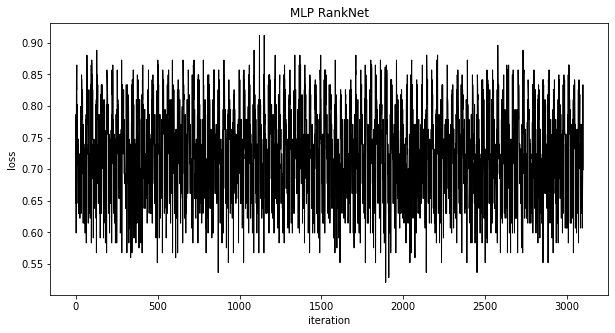

In [74]:
fig = plt.figure(figsize=(10,5))
fig.patch.set_facecolor('xkcd:white')
plt.plot([float(i) for i in log], color = 'black', linewidth=1)
plt.title('MLP RankNet')
plt.xlabel("iteration")
plt.ylabel("loss")

### Statistics

#### Raw data

In [178]:
libr_distr = df_openml['flow_name'].apply(lambda x: x.split('.')[0]).value_counts()

TOP = 10   
libr_distr_top = df_openml.groupby(['task_id']).apply(lambda x: x.nlargest(TOP,['value']))
libr_distr_top = libr_distr_top['flow_name'].apply(lambda x: x.split('.')[0]).value_counts()

<AxesSubplot:title={'center':'Distribution of used libraries on a logarithmic scale'}>

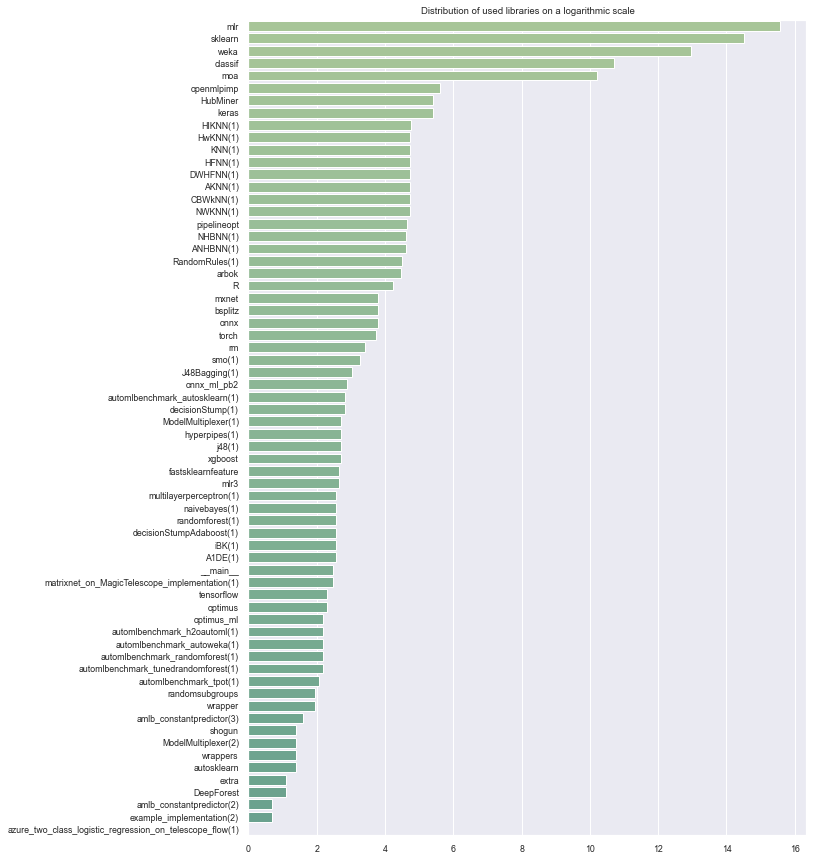

In [179]:
fig = plt.figure(figsize=(10,15))
fig.patch.set_facecolor('xkcd:white')
sns.set(font_scale=0.8)
palette = sns.color_palette("crest", as_cmap=True)
plt.title('Distribution of used libraries on a logarithmic scale')
sns.barplot(y=libr_distr.index[:-30], x=np.log(libr_distr.values)[:-30], palette=palette.colors)

/var/folders/ft/5vplhl0d36b0qq16wf5p_mbh0000gn/T/ipykernel_13193/3786237575.py:8: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "papertype" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(fname = "./libr_distr_top.png", dpi=300, facecolor='w', edgecolor='w',
/var/folders/ft/5vplhl0d36b0qq16wf5p_mbh0000gn/T/ipykernel_13193/3786237575.py:8: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "frameon" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(fname = "./libr_distr_top.png", dpi=300, facecolor='w', edgecolor='w',


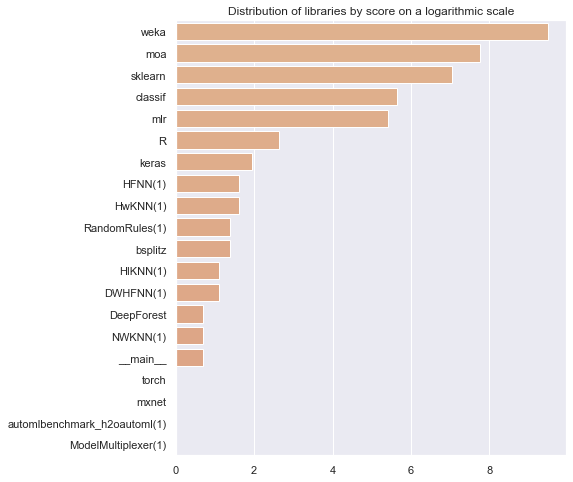

In [180]:
fig = plt.figure(figsize=(7,8))
fig.patch.set_facecolor('xkcd:white')
sns.set(font_scale=1)
palette = sns.color_palette("flare", as_cmap=True)
plt.title('Distribution of libraries by score on a logarithmic scale')
sns.barplot(y=libr_distr_top.index, x=np.log(libr_distr_top.values), palette=palette.colors)

plt.savefig(fname = "./libr_distr_top.png", dpi=300, facecolor='w', edgecolor='w',
            orientation='portrait', papertype=None, format=None, 
            transparent=False, bbox_inches=None, pad_inches=0.1,
            frameon=None, metadata=None)

In [301]:
print(f'Data amount: {len(df_openml)}')
print(f'Datasets: {df_openml.data_id.nunique()}')
print(f'Tasks: {df_openml.task_id.nunique()}')
print(f'Model: {df_openml.flow_name.nunique()}')

Data amount: 8283681
Datasets: 895
Tasks: 1793
Model: 4755


#### Processed data

In [27]:
print(f'Data amount: {len(df_top_merge)}')
print(f'Datasets: {df_top_merge.data_id.nunique()}')
print(f'Tasks: {df_top_merge.task_id.nunique()}')
print(f'Model: {df_top_merge.flow_name.nunique()}')

Data amount: 1230
Datasets: 118
Tasks: 123
Model: 320


In [ ]:
# df_top_merge[df_top_merge['flow_name_type'].apply(lambda x: x.endswith('RandomForest'))]['flow_name_type'].unique()